# m-arcsinh: An Efficient and Reliable Function for SVM and MLP in scikit-learn

## Introduction

The paper introduces *m-arcsinh*, a novel modified version of the inverse hyperbolic sine function, tailored for use as both a kernel in Support Vector Machines (SVM) and as an activation function in Multi-Layer Perceptrons (MLP). Traditional kernel and activation functions in SVM and MLP, while well-established, are limited in number and typically mutually exclusive between the two algorithms, often exhibiting limitations in convergence speed and reliability. The *m-arcsinh* function, implemented in the scikit-learn Python library, aims to address these issues by offering a function that is computationally efficient and robust for both SVM and MLP applications, as demonstrated through testing on fifteen datasets from scikit-learn and the UCI Machine Learning repository.

## Overview

The *m-arcsinh* function, designed as a weighted combination of inverse hyperbolic sine and square root functions, was implemented in Python's scikit-learn library. The function serves as both a kernel function for SVM and an activation function for MLP, addressing limitations in existing approaches.

## Mathematical Foundation
The function is defined as:
* *`m-arcsinh`* = $arcsinh(x) × \frac{1}{3} × \frac{1}{4} × \sqrt{|x|} = arcsinh(x) × \frac{1}{12} × \sqrt{|x|}$

### Function Requirements
For a function to serve as both kernel and activation function, it must:
1. Maximize the margin width in SVM
2. Improve discrimination of input data into target classes via a transfer mechanism of appropriately extended range for MLP

### Design Rationale
* The function combines two key components:
  - Inverse hyperbolic sine function (*arcsinh*): Suitable for MLP
  - Square root function: Appropriate for SVM
* Weights are assigned to optimize both roles:
  - Higher weight (1/3) for *arcsinh*
  - Lower weight (1/4) for square root function

### Mathematical Expression
The m-arcsinh function is defined as:
* $arcsinh(x) × \frac{1}{3} × \frac{1}{4} × \sqrt{|x|} = arcsinh(x) × \frac{1}{12} × \sqrt{|x|}$

The derivative is given by:
* $\frac{\sqrt{|x|}}{12×\sqrt{x^2+1}} + \frac{x \times arcsinh(x)}{24×|x|^{\frac{3}{2}}}$

### Limitations of Existing Functions
* Linear kernel: Not suitable for MLP with non-linearly separable data
* Tanh function: Has extended range with sigmoidal behavior for SVM but may not optimize margin width reliably

## Implementation Details
### Hyperparameters

* **SVM Configuration:**

In [1]:
svm_gamma = 0.001
svm_random_state = 1
svm_class_weight = 'balanced'

* **MLP Configuration:**

In [2]:
random_state = 1
epochs = 300
batch_size = 30

### Dataset Splits
Every dataset is being split 80/20

In [3]:
test_size = 0.2

## Evaluation
### Dataset Coverage
Evaluated across 5 diverse datasets from scikit-learn, including:
* Medical diagnostics (breast cancer)
* Image recognition (handwritten digits, faces)
* Other classifications (wine, iris)

### Comparative Analysis
Benchmarked against standard functions:
* **SVM Kernels:** RBF, poly, sigmoid, linear
* **MLP Activations:** identity, sigmoid, tanh, ReLU

### Performance Metrics
* Accuracy
* Precision
* Recall
* F1-score
* Training time (computational efficiency)

## Code Implementation

In [4]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits, load_breast_cancer, load_iris, fetch_olivetti_faces, load_wine
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import matplotlib.pyplot as plt
import seaborn as sns

### SVM Kernel Implementation

In [5]:
def m_arcsinh_svm(X, Y):
    """
    Implements m-arcsinh as a kernel function for SVM classifier
    
    Parameters:
    X, Y : numpy.ndarray
        Input arrays to classify
    """
    return np.dot((1/3 * np.arcsinh(X)) * (1/4 * np.sqrt(np.abs(X))),
                  (1/3 * np.arcsinh(Y.T)) * (1/4 * np.sqrt(np.abs(Y.T))))

### MLP Activation Implementation

In [6]:
def m_arcsinh_mlp_torch(X):
    """
    Compute the m-arcsinh hyperbolic function for PyTorch tensors.
    
    Parameters:
    -----------
    X : torch.Tensor, shape (n_samples, n_features)
        The input data.
        
    Returns:
    --------
    X_new : torch.Tensor, shape (n_samples, n_features)
        The transformed data.
    """
    return (1/3 * torch.arcsinh(X)) * (1/4 * torch.sqrt(torch.abs(X)))

def inplace_m_arcsinh_derivative(Z, delta):
    """
    Apply the derivative of the hyperbolic m-arcsinh function.
    
    Parameters:
    -----------
    Z : {array-like, sparse matrix}, shape (n_samples, n_features)
        The data which were output from the hyperbolic m-arcsinh 
        activation function during the forward pass.
    delta : {array-like}, shape (n_samples, n_features)
        The back-propagated error signal to be modified in place.
    """
    delta *= (np.sqrt(np.abs(Z))/(12 * np.sqrt(Z**2 + 1)) + (Z * np.arcsinh(Z))/(24 * np.abs(Z)**(3/2)))

# inplace_m_arcsinh_derivative is not needed as PyTorch’s autograd will automatically differentiate m_arcsinh_mlp_torch

# Custom m-arcsinh activation function in PyTorch
class MArcsinhActivation(nn.Module):
    def forward(self, x):
        return m_arcsinh_mlp_torch(x)

# Custom MLP model class
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation='relu'):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        # Choose activation function
        if activation == 'm_arcsinh':
            self.activation = MArcsinhActivation()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'identity':
            self.activation = nn.Identity()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(f"Unknown activation function: {activation}")
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

## Performance Evaluation Methodology

### Metrics and Tools
* **Accuracy Assessment:** Utilized `accuracy_score` from `sklearn.metrics`
* **Reliability Measures:** 
  - Weighted averages of precision, recall, and F1-score
  - Computed using `classification_report` from `sklearn.metrics`

### Computational Performance
* **Hardware Specifications:**
  - Processor: AMD Ryzen 5 5600H
  - Memory: 32 GB DDR4 RAM
* **Performance Metrics:**
  - Training time (measured in seconds)
  - Used to evaluate computational cost impact of different kernel and activation functions

### Performance Evaluation Code

#### Datasets

In [7]:
breast_cancer_data_set = load_breast_cancer()
digits_data_set = load_digits()
faces_data_set = fetch_olivetti_faces()
wine_data_set = load_wine()
iris_data_set = load_iris()

#### SVM

In [8]:
# SVM Kernels to compare
def get_svm_results_for_dataset(data_set):
    svm_kernels = {
        'm_arcsinh': m_arcsinh_svm,
        'rbf': 'rbf',
        'linear': 'linear',
        'poly': 'poly',
        'sigmoid': 'sigmoid'
    }
    
    X_train, X_test, y_train, y_test = train_test_split(data_set.data, data_set.target, test_size=test_size, random_state=svm_random_state)
    
    svm_results = []
    for kernel_name, kernel in svm_kernels.items():
        classifier_svm = svm.SVC(kernel=kernel, gamma=svm_gamma, random_state=svm_random_state, class_weight=svm_class_weight)
        
        # Timing and training
        start_time = time.time()
        classifier_svm.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Prediction and evaluation
        y_pred = classifier_svm.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
        
        svm_results.append({
            'Classifier': 'SVM',
            'Function': kernel_name,
            'Training Time (s)': training_time,
            'Accuracy': accuracy,
            'Weighted Precision': report['weighted avg']['precision'],
            'Weighted Recall': report['weighted avg']['recall'],
            'Weighted F1-score': report['weighted avg']['f1-score']
        })

    return svm_results

#### MLP

In [9]:
def get_mlp_results_for_dataset(data_set):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        data_set.data, data_set.target, test_size=test_size, random_state=random_state
    )
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Prepare data loaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)
    
    # Training function
    def train_model(model, train_loader, criterion, optimizer, epochs=epochs):
        model.train()
        for epoch in range(epochs):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
    # Activation functions to test
    activation_functions = ['m_arcsinh', 'identity', 'relu', 'tanh', 'sigmoid']
    mlp_results = []
    
    def evaluate_model(model, test_loader):
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())
        return all_labels, all_preds
        
    def evaluateMLP(activation_function):
        # Initialize model with dynamic output size
        model = MLPModel(
            input_size=X_train.shape[1], hidden_size=100, output_size=500, activation=activation_function
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train the model
        start_time = time.time()
        train_model(model, train_loader, criterion, optimizer, epochs=10)
        training_time = time.time() - start_time
        
        # Evaluate the model
        y_true, y_pred = evaluate_model(model, test_loader)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
        return {
            'Classifier': 'MLP',
            'Function': activation_function,
            'Training Time (s)': training_time,
            'Accuracy': accuracy,
            'Weighted Precision': precision,
            'Weighted Recall': recall,
            'Weighted F1-score': f1
        }
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    
    for afunc in activation_functions:
        mlp_results.append(evaluateMLP(afunc))

    return mlp_results

### Evaluation Results

#### Breast Cancer Dataset Evaluation

In [10]:
breast_cancer_results_df = pd.DataFrame(get_svm_results_for_dataset(breast_cancer_data_set) + get_mlp_results_for_dataset(breast_cancer_data_set))
breast_cancer_results_df['Dataset'] = 'Breast Cancer'
breast_cancer_results_df

,Classifier,Function,Training Time (s),Accuracy,Weighted Precision,Weighted Recall,Weighted F1-score,Dataset
0,SVM,m_arcsinh,0.028189,0.956140,0.956073,0.956140,0.956027,Breast Cancer
1,SVM,rbf,0.020593,0.938596,0.940758,0.938596,0.939002,Breast Cancer
2,SVM,linear,0.732554,0.938596,0.939001,0.938596,0.938086,Breast Cancer
3,SVM,poly,53.443541,0.938596,0.939001,0.938596,0.938086,Breast Cancer
4,SVM,sigmoid,0.009544,0.631579,0.767313,0.631579,0.488964,Breast Cancer
5,MLP,m_arcsinh,0.320163,0.868421,0.883271,0.868421,0.861823,Breast Cancer
6,MLP,identity,0.295896,0.885965,0.891901,0.885965,0.882477,Breast Cancer
7,MLP,relu,0.300374,0.789474,0.827044,0.789474,0.766073,Breast Cancer
8,MLP,tanh,0.240736,0.877193,0.884547,0.877193,0.872882,Breast Cancer
9,MLP,sigmoid,0.284027,0.868421,0.872940,0.868421,0.864396,Breast Cancer


#### Digits Dataset Evaluation

In [11]:
digits_results_df = pd.DataFrame(get_svm_results_for_dataset(digits_data_set) + get_mlp_results_for_dataset(digits_data_set))
digits_results_df['Dataset'] = 'Digits'
digits_results_df

,Classifier,Function,Training Time (s),Accuracy,Weighted Precision,Weighted Recall,Weighted F1-score,Dataset
0,SVM,m_arcsinh,0.037224,0.988889,0.989395,0.988889,0.988921,Digits
1,SVM,rbf,0.093616,0.994444,0.994753,0.994444,0.994480,Digits
2,SVM,linear,0.040149,0.991667,0.992014,0.991667,0.991713,Digits
3,SVM,poly,0.033391,0.986111,0.986645,0.986111,0.986228,Digits
4,SVM,sigmoid,0.245575,0.738889,0.750517,0.738889,0.728235,Digits
5,MLP,m_arcsinh,0.959981,0.947222,0.949402,0.947222,0.947372,Digits
6,MLP,identity,0.724968,0.955556,0.959564,0.955556,0.955917,Digits
7,MLP,relu,0.790432,0.972222,0.973341,0.972222,0.971938,Digits
8,MLP,tanh,0.765688,0.983333,0.983735,0.983333,0.983324,Digits
9,MLP,sigmoid,0.751948,0.969444,0.970563,0.969444,0.969564,Digits


#### Faces Dataset Evaluation

In [12]:
faces_results_df = pd.DataFrame(get_svm_results_for_dataset(faces_data_set) + get_mlp_results_for_dataset(faces_data_set))
faces_results_df['Dataset'] = 'Faces'
faces_results_df

,Classifier,Function,Training Time (s),Accuracy,Weighted Precision,Weighted Recall,Weighted F1-score,Dataset
0,SVM,m_arcsinh,0.108649,0.9000,0.943958,0.9000,0.885265,Faces
1,SVM,rbf,0.371444,0.1375,0.927083,0.1375,0.118333,Faces
2,SVM,linear,0.261103,0.9625,0.981250,0.9625,0.960119,Faces
3,SVM,poly,0.256467,0.7125,0.821657,0.7125,0.688803,Faces
4,SVM,sigmoid,0.313156,0.0000,1.000000,0.0000,0.000000,Faces
5,MLP,m_arcsinh,0.607604,0.0250,0.964689,0.0250,0.003906,Faces
6,MLP,identity,0.550739,0.6375,0.846101,0.6375,0.591528,Faces
7,MLP,relu,0.604999,0.1250,0.887274,0.1250,0.096506,Faces
8,MLP,tanh,0.565646,0.0250,0.975651,0.0250,0.001268,Faces
9,MLP,sigmoid,0.578728,0.0000,1.000000,0.0000,0.000000,Faces


#### Wine Dataset Evaluation

In [13]:
wine_results_df = pd.DataFrame(get_svm_results_for_dataset(wine_data_set) + get_mlp_results_for_dataset(wine_data_set))
wine_results_df['Dataset'] = 'Wine'
wine_results_df

,Classifier,Function,Training Time (s),Accuracy,Weighted Precision,Weighted Recall,Weighted F1-score,Dataset
0,SVM,m_arcsinh,0.002021,0.916667,0.921296,0.916667,0.916035,Wine
1,SVM,rbf,0.004999,0.777778,0.800262,0.777778,0.783179,Wine
2,SVM,linear,0.134362,0.944444,0.946296,0.944444,0.944106,Wine
3,SVM,poly,0.082153,0.944444,0.946296,0.944444,0.944106,Wine
4,SVM,sigmoid,0.003051,0.361111,0.769290,0.361111,0.191610,Wine
5,MLP,m_arcsinh,0.096783,0.666667,0.826667,0.666667,0.589298,Wine
6,MLP,identity,0.102971,0.638889,0.819444,0.638889,0.564815,Wine
7,MLP,relu,0.092994,0.388889,0.762346,0.388889,0.217778,Wine
8,MLP,tanh,0.075438,0.666667,0.826667,0.666667,0.589298,Wine
9,MLP,sigmoid,0.086478,0.361111,0.756481,0.361111,0.292623,Wine


#### Iris Dataset Evaluation

In [14]:
iris_results_df = pd.DataFrame(get_svm_results_for_dataset(iris_data_set) + get_mlp_results_for_dataset(iris_data_set))
iris_results_df['Dataset'] = 'Iris'
iris_results_df

,Classifier,Function,Training Time (s),Accuracy,Weighted Precision,Weighted Recall,Weighted F1-score,Dataset
0,SVM,m_arcsinh,0.001998,0.966667,0.971429,0.966667,0.967282,Iris
1,SVM,rbf,0.004004,0.700000,0.822727,0.700000,0.630677,Iris
2,SVM,linear,0.002995,1.000000,1.000000,1.000000,1.000000,Iris
3,SVM,poly,0.002508,0.433333,0.754444,0.433333,0.262016,Iris
4,SVM,sigmoid,0.002997,0.433333,0.754444,0.433333,0.262016,Iris
5,MLP,m_arcsinh,0.096241,0.433333,0.754444,0.433333,0.262016,Iris
6,MLP,identity,0.071042,0.566667,0.863158,0.566667,0.462667,Iris
7,MLP,relu,0.062080,0.200000,0.429825,0.200000,0.096000,Iris
8,MLP,tanh,0.064287,0.566667,0.863158,0.566667,0.462667,Iris
9,MLP,sigmoid,0.058241,0.566667,0.863158,0.566667,0.462667,Iris


### Function comparison

#### Let's take a look which function performed the best for each *Classifier* on each of the datasets

In [15]:
all_results = pd.concat(
    [breast_cancer_results_df, digits_results_df, faces_results_df, wine_results_df, iris_results_df],
    ignore_index=True
)

In [16]:
def rank_functions(df):
    ranked = df.copy()
    
    # Separating SVM and MLP
    svm = ranked[ranked['Classifier'] == 'SVM']
    mlp = ranked[ranked['Classifier'] == 'MLP']
    
    # Ranking by accuracy (higher is better) and training time (lower is better)
    svm['Accuracy Rank'] = svm['Accuracy'].rank(ascending=False)
    svm['Time Rank'] = svm['Training Time (s)'].rank(ascending=True)
    svm['Overall Rank'] = (svm['Accuracy Rank'] + svm['Time Rank']).rank(ascending=True)
    
    mlp['Accuracy Rank'] = mlp['Accuracy'].rank(ascending=False)
    mlp['Time Rank'] = mlp['Training Time (s)'].rank(ascending=True)
    mlp['Overall Rank'] = (mlp['Accuracy Rank'] + mlp['Time Rank']).rank(ascending=True)
    
    return pd.concat([svm, mlp])

# Applying ranking within each dataset
ranked_results = all_results.groupby('Dataset', group_keys=False).apply(rank_functions)

top_performers = ranked_results.sort_values(['Dataset', 'Overall Rank']).groupby(['Dataset', 'Classifier']).head(1)

top_performers[['Dataset', 'Classifier', 'Function', 'Accuracy', 'Training Time (s)', 'Overall Rank']]

,Dataset,Classifier,Function,Accuracy,Training Time (s),Overall Rank
0,Breast Cancer,SVM,m_arcsinh,0.956140,0.028189,1.0
8,Breast Cancer,MLP,tanh,0.877193,0.240736,1.0
18,Digits,MLP,tanh,0.983333,0.765688,1.0
10,Digits,SVM,m_arcsinh,0.988889,0.037224,2.5
20,Faces,SVM,m_arcsinh,0.900000,0.108649,1.0
26,Faces,MLP,identity,0.637500,0.550739,1.0
40,Iris,SVM,m_arcsinh,0.966667,0.001998,1.0
49,Iris,MLP,sigmoid,0.566667,0.058241,1.0
30,Wine,SVM,m_arcsinh,0.916667,0.002021,1.0
38,Wine,MLP,tanh,0.666667,0.075438,1.0


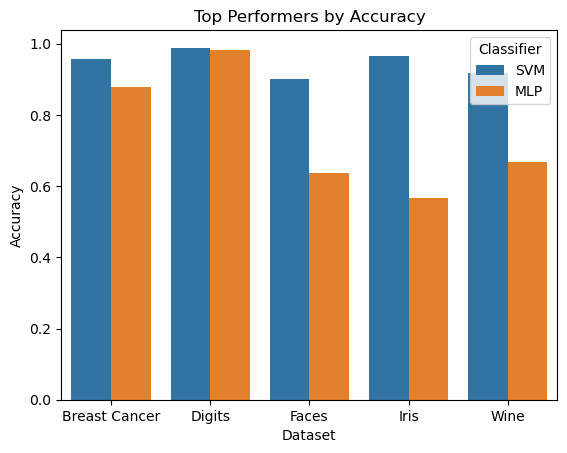

In [17]:
sns.barplot(data=top_performers, x='Dataset', y='Accuracy', hue='Classifier')
plt.title('Top Performers by Accuracy')
plt.show()